In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import config

from HySpecLab.feature_selection import InterbandRedundancySelector 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [2]:
from dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
x, y = dataset.get(dataframe=True)

## Normalization (Z-Score)

In [3]:
x_normalized = (x.values - x.mean().values) / x.std().values
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)

# Feature Selection

In [4]:
selector = InterbandRedundancySelector(threshold=10)
selector.fit(x_normalized.values)

InterbandRedundancySelector(threshold=10)

# Select samples

In [105]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

n_samples = 512
sampling_strategy = {class_id:n_samples for class_id in np.unique(y)}
print(sampling_strategy)
nm = NearMiss(sampling_strategy=sampling_strategy, version=3)
x_selected, y_selected = nm.fit_resample(x_normalized, y)

{0: 512, 1: 512}


# Torch tensor

In [82]:
from torch.nn.functional import one_hot

x_tensor = torch.tensor(x_selected.values)
y_tensor = one_hot(torch.tensor(y_selected.values.flatten()))
print('X Shape: {}; Y Shape: {}'.format(x_tensor.shape, y_tensor.shape))

X Shape: torch.Size([1024, 116]); Y Shape: torch.Size([1024, 2])


In [97]:
y_tensor.size(1) 

{i:100 for i in range(0,y_tensor.size(1))}

{0: 100, 1: 100}

### Shuffle

In [83]:
torch.manual_seed(123)
shuffle_idx = torch.randperm(x_tensor.shape[0])
x_tensor = x_tensor[shuffle_idx]
y_tensor = y_tensor[shuffle_idx]

# Cosos

## PMF

Gaussian maximum entropy: $H(X) = \frac{1}{2}(1 + log(2\sigma^2\pi))$

In [84]:
# from scipy.stats import entropy

# mean = 0.5
# std = 1.8
# gaussian = np.random.normal(loc=mean, scale=std, size=(1000))
# gaussian_dist = np.histogram(gaussian, bins=35)[0]

# theorical_entropy = 1/2*(1+np.log2(2*mean*std))
# entropy_value = entropy(gaussian_dist[0], base=2)

# from IPDL.functional import matrix_estimator
# from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis

# n = gaussian.size
# d = 1
# gamma = 1
# sigma = gamma * (n ** (-1 / (4 + d))) * np.sqrt(d)
# print(sigma)
# Kx, Ax = matrix_estimator(torch.tensor(gaussian.reshape(-1, 1)), sigma=3.5)
# kernel_based_entropy = renyis.entropy(Ax) 

# print(theorical_entropy, entropy_value, kernel_based_entropy)

# Kernel-Based Entropy

In [93]:
n = x_tensor.size(0)
d = x_tensor.size(1)
d = 1
gamma = 0.5
sigma = gamma * (n ** (-1 / (4 + d)))
sigma_y = gamma * (n ** (-1 / (4 + 2))) 
print(sigma)
print(sigma_y)

0.12499999999999999
0.15749013123685915


Target entropy: 1.0003081560134888 bits


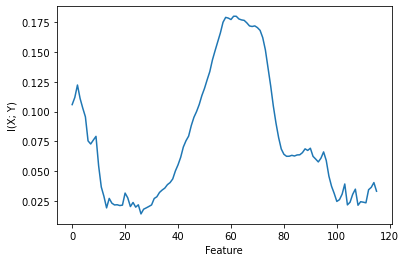

In [94]:
from IPDL.functional import matrix_estimator
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis


n_features = x_tensor.size(1)
sigma_y = gamma * (n ** (-1 / (4 + 2))) 
Ky, Ay = matrix_estimator(y_tensor, sigma=sigma_y)

mi_estimation = np.zeros(x_tensor.size(1))
# for feature in range()

for feature in range(n_features):
    Kx, Ax = matrix_estimator(x_tensor[:, feature].reshape(-1, 1), sigma=sigma)
    mi_estimation[feature] = renyis.mutualInformation(Ax, Ay)


# print(renyis.entropy(Ax).item())
print('Target entropy: {} bits'.format(renyis.entropy(Ay)))
plt.plot(mi_estimation)
plt.ylabel('I(X; Y)')
plt.xlabel('Feature')
plt.show()


In [108]:
mi_estimation.shape

(116,)

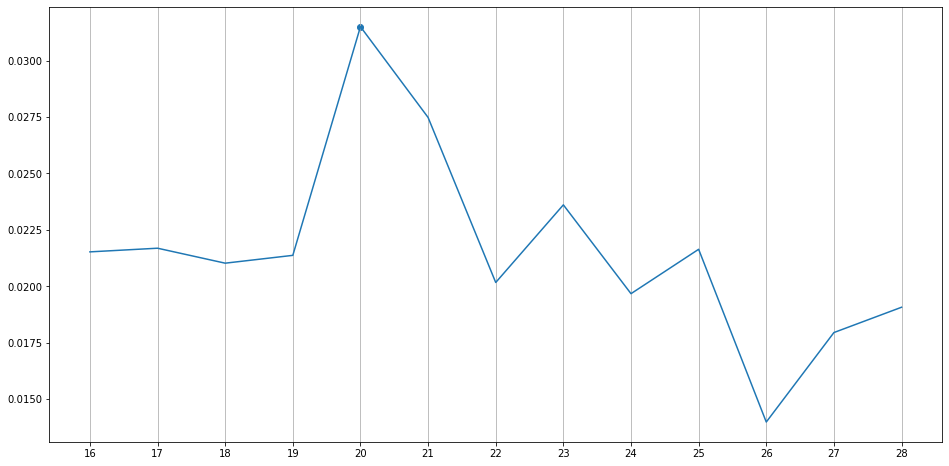

In [109]:
independent_var = 20
available_features = np.arange(116)
cluster = selector._clusterize(independent_var, available_features)

max_mi = np.argmax(mi_estimation[cluster])

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(mi_estimation[cluster])
ax.scatter(max_mi, mi_estimation[cluster][max_mi])
ax.set_xticks(np.arange(len(cluster)))
ax.set_xticklabels(cluster)
plt.grid(True, axis='x')
plt.show()

In [ ]:
mi_estimation[max_mi]

In [ ]:
print(mi_estimation[cluster])
print(np.argmax(mi_estimation[cluster]))

In [ ]:
from scipy.signal import find_peaks

signal_peaks = find_peaks(mi_estimation)[0]
plt.plot(mi_estimation)
plt.scatter(signal_peaks, mi_estimation[signal_peaks])
plt.show()

In [ ]:
n ** (-1 / (4 + d)) * 2

In [ ]:
from torch.nn import Sigmoid
model = Sigmoid()

sigmoid = model(torch.arange(-10, 10, 0.01))
# plt.plot(sigmoid)

gaussian = np.random.normal(loc=0.0, scale=1.0, size=(100))
plt.hist(gaussian)
print(entropy(gaussian))

In [ ]:
from IPDL.functional import matrix_estimator

Ky, Ay = matrix_estimator(y_tensor, sigma=.1)

In [ ]:
from IPDL import MatrixEstimator
from IPDL.optim import AligmentOptimizer

x_estimator = MatrixEstimator(0.1)
matrix_optimizer = AligmentOptimizer(x_estimator, beta=.99, n_sigmas=200)

In [ ]:
x_estimator.eval()
# x_estimator(x_tensor[:, 10].reshape((-1, 1)))
x_estimator(x_tensor[:, 45:60])
matrix_optimizer.step(Ky.to(device))
# print(x_estimator)
# print(estimator.get_matrix().shape)


In [ ]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis

renyis.mutualInformation(x_estimator.get_matrix(), Ay)
# x_estimator

In [ ]:
print(renyis.entropy(x_estimator.get_matrix()))
print(renyis.entropy(Ay))